# A Practical Script to Using Visual Studio Code and Python for Machine Learning in Small‑Molecule Drug Discovery, Design, and Optimization

## Purpose of This Script

This script provides a **step‑by‑step, end‑to‑end workflow** for applying Python‑based machine learning to **small‑molecule drug discovery** using **Visual Studio Code (VS Code)** as the primary development environment. It is designed for students, researchers, and professionals in medicinal chemistry, CADD, and pharmaceutical sciences.

The guide emphasizes **practical implementation**, reproducibility, and industry‑relevant best practices across:

* Data cleaning and curation
* Molecular descriptor calculation
* QSAR and ML model development
* Model validation and interpretation
* Bioactivity prediction and virtual screening
* Drug‑likeness and Lipinski filtering
* Visualization and reporting
* Deployment and reuse of models

**Author:** **Abdullahi Abubakar Sadiq**

_Date:_ **_20th January 2026_**


1. IMPORT LIBRARIES

In [ ]:
# pandas: handles tabular data like Excel or CSV files
import pandas as pd

# rdkit: a chemical informatics library for molecule manipulation
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Avalon import pyAvalonTools

# numpy: numerical operations for arrays (used in fingerprints and ML)
import numpy as np

# scikit-learn: machine learning tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ML libraries for advanced models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# joblib: save and load trained models
import joblib


2. READ DATA

In [ ]:
from rdkit import Chem
import pandas as pd

# ===========================
# LOAD & CLEAN TRAINING DATA
# ===========================

# Load training dataset
df = pd.read_csv("Train.csv")

# Defensive column selection
required_cols = ["Smiles", "pChEMBL Value"]
df = df[required_cols + [c for c in df.columns if c not in required_cols]]

# Track initial size
initial_train_rows = df.shape[0]

# Drop missing critical values
df = df.dropna(subset=["Smiles", "pChEMBL Value"]).reset_index(drop=True)

# Ensure correct data types and normalize SMILES
df["Smiles"] = df["Smiles"].astype(str).str.strip()
df["pChEMBL Value"] = pd.to_numeric(df["pChEMBL Value"], errors="coerce")

# Drop rows that became invalid after coercion
df = df.dropna(subset=["pChEMBL Value"]).reset_index(drop=True)

# Remove duplicate SMILES (keep first occurrence)
df = df.drop_duplicates(subset=["Smiles"]).reset_index(drop=True)

# Validate SMILES with RDKit
def is_valid_smiles(smi):
    return Chem.MolFromSmiles(smi) is not None

df["valid_smiles"] = df["Smiles"].apply(is_valid_smiles)
df = df[df["valid_smiles"]].drop(columns="valid_smiles").reset_index(drop=True)

# Final report
print(
    f"Training dataset cleaned: "
    f"{initial_train_rows - df.shape[0]} rows removed, "
    f"{df.shape[0]} valid compounds remaining."
)


Dataset cleaned: 606 rows removed, 3251 remaining.


3. CONVERT SMILES TO MOLECULES

In [ ]:
def smiles_to_mols(smiles_list):
    """
    Convert SMILES strings to RDKit molecule objects.
    Ignore invalid SMILES.
    """
    mols = []       # List to store valid molecules
    valid_idx = []  # Index of valid molecules
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)  # Convert SMILES to molecule
        if mol:  # Only keep valid molecules
            mols.append(mol)
            valid_idx.append(i)
    return mols, valid_idx

4. CALCULATE FINGERPRINTS

In [ ]:
def calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024):
    """
    Compute molecular fingerprints (ECFP or Avalon) for all molecules.
    Fingerprints are numeric representations of molecular structure.
    """
    smiles_list = df[smiles_col]
    mols, valid_idx = smiles_to_mols(smiles_list)
    fingerprints = []

    for mol in mols:
        # ECFP (Morgan) fingerprint
        if method == 'ecfp':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        # Avalon fingerprint
        elif method == 'avalon':
            fp = pyAvalonTools.GetAvalonFP(mol, nBits=nBits)
        else:
            raise ValueError("Method must be 'ecfp' or 'avalon'")

        # Convert fingerprint to numeric array
        fp_np = np.zeros((nBits,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(fp, fp_np)
        fingerprints.append(fp_np)

    # Create DataFrame for fingerprints
    prefix = method.upper()
    fp_df = pd.DataFrame(fingerprints, columns=[f'{prefix}_{i}' for i in range(nBits)])
    fp_df.index = valid_idx

    # Keep only valid molecules
    df_valid = df.iloc[valid_idx].reset_index(drop=True)
    fp_df = fp_df.reset_index(drop=True)

    # Combine original data and fingerprint features
    return pd.concat([df_valid, fp_df], axis=1)


5. CREATE FINGERPRINT FEATURES

In [ ]:
df_with_ecfp = calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024)

# Define features (X) and target (y)
X = df_with_ecfp.drop(columns=['Smiles', 'Molecule ChEMBL ID', 'pChEMBL Value'])
y = df_with_ecfp['pChEMBL Value']

# Remove constant columns
X = X.loc[:, X.nunique() > 1]


[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerator
[23:27:56] DEPRECATION WARNING: please use MorganGenerat

6. SPLIT DATA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# 80% training, 20% testing

7. DEFINE MODELS

In [ ]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
}


8. TRAIN AND EVALUATE MODELS

In [ ]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)        # Train model
    y_pred = model.predict(X_test)     # Predict on test set

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, mse, rmse, r2])

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model","MAE","MSE","RMSE","R2"])
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
results_df["Rank"] = results_df["RMSE"].rank(method="first")
print("\nTop Models Ranked by RMSE:")
print(results_df)


Training RandomForest...
Training GradBoost...
Training AdaBoost...
Training HistGradientBoosting...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 793
[LightGBM] [Info] Start training from score 7.157150

Top Models Ranked by RMSE:
                  Model       MAE       MSE      RMSE        R2  Rank
0               XGBoost  0.441458  0.379116  0.615724  0.698681   1.0
1          RandomForest  0.436412  0.392886  0.626806  0.687737   2.0
2  HistGradientBoosting  0.452218  0.402307  0.634277  0.680249   3.0
3              LightGBM  0.452218  0.402307  0.634277  0.680249   4.0
4              CatBoost  0.463266  0.414445  0.643774

9. RANDOMIZED HYPERPARAMETER SEARCH (OPTIMIZATION)

In [ ]:
param_dist = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'max_depth': [None, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.8, 0.6],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model_random = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 471

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


10. PREDICTION AND CROSS-VALIDATION

In [ ]:
# Predict test set
pred_y_test = best_model_random.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_y_test))
mae = mean_absolute_error(y_test, pred_y_test)
r2 = r2_score(y_test, pred_y_test)
print("Random Forest Tuned Model:")
print("RMSE:", rmse, "MAE:", mae, "R2:", r2)

# Cross-validation to estimate performance stability
scoring_metrics = {
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}

cv_results = {}
for name, scoring in scoring_metrics.items():
    scores = cross_val_score(best_model_random, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    if name in ["RMSE", "MAE"]:
        scores = -scores
    cv_results[name] = (np.mean(scores), np.std(scores))

print("Cross-Validation Performance (5-fold):")
for metric, (mean_score, std_score) in cv_results.items():
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


Random Forest Tuned Model:
RMSE: 0.5916532806694512 MAE: 0.4136957194060422 R2: 0.7217793934507224
Cross-Validation Performance (5-fold):
RMSE: 0.6237 ± 0.0229
MAE: 0.4381 ± 0.0110
R2: 0.7045 ± 0.0282


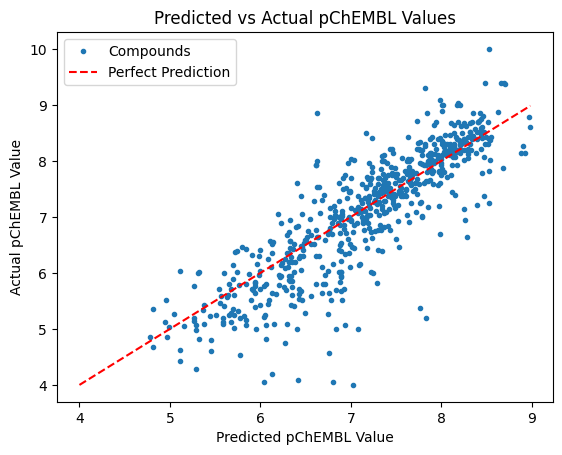

In [ ]:
plt.plot(pred_y_test, y_test, '.', label="Compounds" )

min_val = min(min(y_test), min(pred_y_test))
max_val = max(min(y_test), max(pred_y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction' )

plt.xlabel("Predicted pChEMBL Value")
plt.ylabel("Actual pChEMBL Value")
plt.title("Predicted vs Actual pChEMBL Values")
plt.legend()

plt.show()

11. SAVE MODEL

In [ ]:
joblib.dump(best_model_random, "best_random_forest_model.PARP")
print("✅ Model saved as best_random_forest_model.PARP")

✅ Model saved as best_random_forest_model.PARP


12. APPLY MODEL TO NEW DATA

In [ ]:
# ===========================
# LOAD & CLEAN TEST DATA
# ===========================

# Load test dataset
test_df = pd.read_csv("Test.csv")

# Defensive column selection
required_cols = ["Smiles"]
test_df = test_df[required_cols + [c for c in test_df.columns if c not in required_cols]]

# Track initial size
initial_test_rows = test_df.shape[0]

# Drop missing SMILES
test_df = test_df.dropna(subset=["Smiles"]).reset_index(drop=True)

# Ensure correct data type and normalize
test_df["Smiles"] = test_df["Smiles"].astype(str).str.strip()

# Remove duplicate SMILES
test_df = test_df.drop_duplicates(subset=["Smiles"]).reset_index(drop=True)

# Validate SMILES with RDKit
def is_valid_smiles(smi):
    return Chem.MolFromSmiles(smi) is not None

test_df["valid_smiles"] = test_df["Smiles"].apply(is_valid_smiles)
test_df = test_df[test_df["valid_smiles"]].drop(columns="valid_smiles").reset_index(drop=True)

# Report cleaning summary
print(
    f"Test dataset cleaned: "
    f"{initial_test_rows - test_df.shape[0]} rows removed, "
    f"{test_df.shape[0]} valid compounds remaining."
)


Test dataset cleaned: 4422 rows removed, 6199 valid compounds remaining.


In [ ]:
test_df.columns

Index(['Smiles', 'Compound Name ID'], dtype='object')

In [ ]:
# ===========================
# PREDICTION & ACTIVITY SUMMARY
# ===========================

# Generate predictions
test_df_with_ecfp = calculate_fingerprints(test_df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024)
PARP_X = test_df_with_ecfp.drop(columns=['Smiles', 'Compound Name ID'])
PARP_X_aligned = PARP_X.reindex(columns=X_train.columns, fill_value=0)
test_df['Predictions'] = best_model_random.predict(PARP_X_aligned)


[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerator
[00:31:20] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
# Classify activity
threshold = 6.5
test_df["Activity"] = (test_df["Predictions"] >= threshold).astype(int)

# Summary report
num_active = test_df["Activity"].sum()
num_total = len(test_df)
print(f"✅ Activity Summary (Threshold = {threshold}):")
print(f"Total molecules evaluated: {num_total}")
print(f"Predicted active molecules: {num_active}")
print(f"Predicted inactive molecules: {num_total - num_active}")
print(f"Percentage active: {num_active / num_total * 100:.2f}%")


✅ Activity Summary (Threshold = 6.5):
Total molecules evaluated: 6199
Predicted active molecules: 483
Predicted inactive molecules: 5716
Percentage active: 7.79%


In [ ]:
test_df

,Smiles,Compound Name ID,Predictions,Activity,Mol,MolWt,LogP,nHA,nHD
0,[2H]N1C=NC2=CC=CC=C21,(1-~2~H)-1H-Benzimidazole,5.943675,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83D...,119.145102,1.56290,1,1
1,[2H]C1=NC2=CC=CC=C2N1,"(2-(2)H)-1H-1,3-benzodiazole",6.225757,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83D...,119.145102,1.56290,1,1
2,C1=CC=C2C(=C1)NC=N2,Benzimidazole,5.803363,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83D...,118.139000,1.56290,1,1
3,C1=C2C(=CN=N1)N=CN2,"1H-Imidazo[4,5-d]pyridazine",5.850573,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83D...,120.115000,0.35290,3,1
4,C1=CC2=C(N=C1)N=C[NH2+]2,"1H-imidazo[4,5-b]pyridin-1-ium",6.087895,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83D...,120.135000,-0.05010,2,1
...,...,...,...,...,...,...,...,...,...
6194,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CN,"8-(aminomethyl)-1,3-dimethyl-7H-purine-2,6-dione",6.441452,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83C...,209.209000,-1.58100,6,2
6195,CC1=CC=C(C=C1)NCCCl,"Benzenamine, N-(2-chloroethyl)-4-methyl-",6.120482,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83C...,169.655000,2.64572,1,1
6196,CC1=C2C=CC(=O)C=CC2=C(N1C)C,"Cyclohepta(c)pyrrol-6(2H)-one, 1,2,3-trimethyl-",6.282135,0,<rdkit.Chem.rdchem.Mol object at 0x000001FE83C...,187.242000,2.15534,2,0
6197,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CO,8-(Hydroxymethyl)theophylline,6.531115,1,<rdkit.Chem.rdchem.Mol object at 0x000001FE83C...,210.193000,-1.54740,6,2


13. LIPINSKI FILTER (DRUG-LIKENESS)

In [ ]:
from rdkit.Chem import Descriptors

# Compute molecular descriptors

def safe_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol if mol else None

test_df["Mol"] = test_df["Smiles"].apply(safe_mol)
test_df = test_df[test_df["Mol"].notnull()]

test_df["Mol"] = test_df["Smiles"].apply(lambda x: Chem.MolFromSmiles(x))
test_df['MolWt'] = test_df['Mol'].apply(Descriptors.MolWt)
test_df['LogP'] = test_df['Mol'].apply(Descriptors.MolLogP)
test_df['nHA'] = test_df['Mol'].apply(Descriptors.NumHAcceptors)
test_df['nHD'] = test_df['Mol'].apply(Descriptors.NumHDonors)

# Apply Lipinski rule
def calculate_lipinski(row):
    if row['MolWt'] > 500 or row['LogP'] > 5 or row['nHA'] > 10 or row['nHD'] > 5:
        return 0
    else:
        return 1

Choice_Compounds = test_df[test_df["Activity"] == 1].copy()
Choice_Compounds["Lipinski"] = Choice_Compounds.apply(calculate_lipinski, axis=1)
lipinski_pass = Choice_Compounds[Choice_Compounds["Lipinski"] == 1]


In [ ]:
lipinski_pass.columns

Index(['Smiles', 'Compound Name ID', 'Predictions', 'Activity', 'Mol', 'MolWt',
       'LogP', 'nHA', 'nHD', 'Lipinski'],
      dtype='object')

In [ ]:
Lipinski_Pass_Compounds= lipinski_pass.drop(columns=['Mol','MolWt', 'LogP', 'nHA', 'nHD'])

In [ ]:
Lipinski_Pass_Compounds.to_csv("PARP_lipinski_pass_6.5_CPDS.csv", index=False)
print("✅ Saved Lipinski-passing compounds")

✅ Saved Lipinski-passing compounds


In [ ]:
len(Lipinski_Pass_Compounds)

483